# Denoising autoencoder

 The two autoencoders that we have explored in the previous two recipes are examples
of Undercomplete Autoencoders because the hidden layer in them has a lower dimension
as compared to the input (output) layer. Denoising autoencoder belongs to the class of
Overcomplete Autoencoders because it works better when the dimensions of the hidden
layer are more than the input layer.
A denoising autoencoder learns from a corrupted (noisy) input; it feeds its encoder network
the noisy input and then the reconstructed image from the decoder is compared with the
original input. The idea is that this will help the network learn how to denoise an input. It
will no longer just make a pixel-wise comparison, but in order to denoise, it will learn the
information of neighbouring pixels as well.

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import math

 A denoising autoencoder will also have the KL divergence penalty term; it will differ from
the sparse autoencoder of the previous recipe in two main aspects. First, n_hidden , the
number of hidden units in the bottleneck layer is more than the number of units in the input
layer, m, that is n_hidden > m . Second, the input to the encoder is corrupted input; to do
this in TensorFlow, we add the function corrupt

In [2]:
def corruption(x, noise_factor = 0.3):
    #corruption of the input
    noisy_imgs = x + noise_factor * np.random.randn(*x.shape)
    noisy_imgs = np.clip(noisy_imgs, 0., 1.)
    return noisy_imgs
    #Difference between Denoising and previous 2

In [4]:
mnist = input_data.read_data_sets("MNIST_data/")
trX, trY, teX, teY = mnist.train.images, mnist.train.labels,mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Next, we define the main component of this code--the DenoisingAutoEncoder
class. The class is very similar to the SparseAutoEncoder class that we made in
the previous recipe. Here, we have a placeholder for the noisy image; this noisy
input is fed to the encoder. The reconstruction error is now the difference
between the original clean image and the output of the decoder when the noisy
image is the input. We retain the sparsity penalty term here. The fit function thus
takes both the original image and the noisy image as its argument.

In [18]:
class DenoisingAutoEncoder(object):
    def __init__(self, m, n, eta = 0.01):
        """
        m: Number of neurons in input/output layer
        n: number of neurons in hidden layer
        """
        self._m = m
        self._n = n
        self.learning_rate = eta
        # Create the Computational graph
        # Weights and biases
        self._W1 = tf.Variable(tf.random_normal(shape=(self._m,self._n)))
        self._W2 = tf.Variable(tf.random_normal(shape=(self._n,self._m)))
        self._b1 = tf.Variable(np.zeros(self._n).astype(np.float32))
        #bias for hidden layer
        self._b2 = tf.Variable(np.zeros(self._m).astype(np.float32)) 
        #bias for output layer
        # Placeholder for inputs
        self._X = tf.placeholder('float', [None, self._m])
        self._X_noisy = tf.placeholder('float', [None, self._m])
        self.y = self.encoder(self._X_noisy)
        self.r = self.decoder(self.y)
        error = self._X - self.r
        self._loss = tf.reduce_mean(tf.pow(error, 2))
        #self._loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=self._X, logits = self.r))
        alpha = 0.05
        kl_div_loss = tf.reduce_sum(self.kl_div(0.02, tf.reduce_mean(self.y,0)))
        loss = self._loss + alpha * kl_div_loss
        self._opt = tf.train.AdamOptimizer(self.learning_rate).minimize(loss)
    def encoder(self, x):
        h = tf.matmul(x, self._W1) + self._b1
        return tf.nn.sigmoid(h)
    def decoder(self, x):
        h = tf.matmul(x, self._W2) + self._b2
        return tf.nn.sigmoid(h)
    def set_session(self, session):
        self.session = session
    def reconstruct(self,x):
        h = self.encoder(x)
        r = self.decoder(h)
        return self.session.run(r, feed_dict={self._X: x})
    def reduced_dimension(self,x):
        h = self.encoder(x)
        return self.session.run(h, feed_dict={self._X: x})
    def kl_div(self, rho, rho_hat):
        term2_num = tf.constant(1.)- rho
        term2_den = tf.constant(1.) - rho_hat
        kl = self.logfunc(rho,rho_hat) + self.logfunc(term2_num, term2_den)
        return kl
    def logfunc(self, x1, x2):
        return tf.multiply( x1, tf.log(tf.div(x1,x2)))
    def corrupt(self,x):
        return x * tf.cast(tf.random_uniform(shape=tf.shape(x),minval=0,maxval=2),tf.float32)
    def getWeights(self):
        return self.session.run([self._W1, self._W2,self._b1, self._b2])
    def fit(self, X, Xorg, epochs = 1, batch_size = 100):
        N, D = X.shape
        num_batches = N // batch_size
        obj = []
        for i in range(epochs):
            #X = shuffle(X)
            for j in range(num_batches):
                batch = X[j * batch_size: (j * batch_size + batch_size)]
                batchO = Xorg[j * batch_size: (j * batch_size + batch_size)]
                _, ob = self.session.run([self._opt,self._loss], feed_dict={self._X:batchO, self._X_noisy: batch})
                if j % 100 == 0:
                    print('training epoch {0} batch {2} cost {1}'.format(i,ob, j))
                    obj.append(ob)
        return obj

In [19]:
n_hidden = 800
Xtrain = trX.astype(np.float32)
Xtrain_noisy = corruption(Xtrain).astype(np.float32)
Xtest = teX.astype(np.float32)
#noise = Xtest * np.random.randint(0, 2, Xtest.shape).astype(np.float32)
Xtest_noisy = corruption(Xtest).astype(np.float32) 
#Xtest * (1-0.3)+ noise * (0.3)
_, m = Xtrain.shape
dae = DenoisingAutoEncoder(m, n_hidden)

In [20]:
#Initialize all variables
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    dae.set_session(sess)
    err = dae.fit(Xtrain_noisy, Xtrain, epochs=10)
    out = dae.reconstruct(Xtest_noisy[0:100])
    W1, W2, b1, b2 = dae.getWeights()
    red = dae.reduced_dimension(Xtrain)

training epoch 0 batch 0 cost 0.46098852157592773
training epoch 0 batch 100 cost 0.08825340121984482
training epoch 0 batch 200 cost 0.06681940704584122
training epoch 0 batch 300 cost 0.059456076472997665
training epoch 0 batch 400 cost 0.04974064230918884
training epoch 0 batch 500 cost 0.04812672361731529
training epoch 1 batch 0 cost 0.04439686983823776
training epoch 1 batch 100 cost 0.03856393322348595
training epoch 1 batch 200 cost 0.03704196959733963
training epoch 1 batch 300 cost 0.03757206350564957
training epoch 1 batch 400 cost 0.03398340940475464
training epoch 1 batch 500 cost 0.035256847739219666
training epoch 2 batch 0 cost 0.03426893800497055
training epoch 2 batch 100 cost 0.030588453635573387
training epoch 2 batch 200 cost 0.03059295006096363
training epoch 2 batch 300 cost 0.032016631215810776
training epoch 2 batch 400 cost 0.02949076145887375
training epoch 2 batch 500 cost 0.03114391677081585
training epoch 3 batch 0 cost 0.030288254842162132
training epoch 

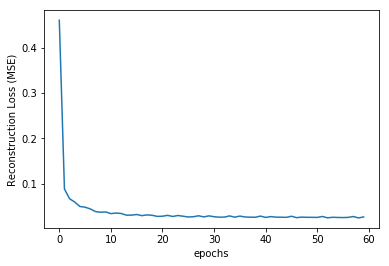

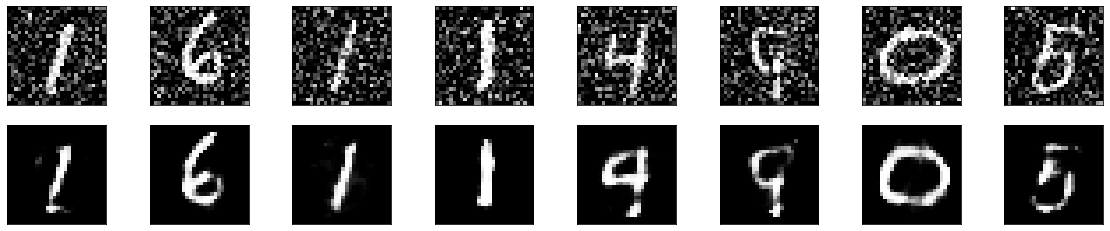

In [25]:
plt.plot(err)
plt.xlabel('epochs')
plt.ylabel('Reconstruction Loss (MSE)')
# Plotting original and reconstructed images
row, col = 2, 8
idx = np.random.randint(0, 100, row * col // 2)
f, axarr = plt.subplots(row, col, sharex=True, sharey=True, figsize=(20,4))
for fig, row in zip([Xtest_noisy,out], axarr):
    for i,ax in zip(idx,row):
        ax.imshow(fig[i].reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)